<a href="https://colab.research.google.com/github/saugatbh/RainfallDataAnalysis/blob/main/BhubhaneshwarPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from math import sqrt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional,GRU
from keras.layers import Flatten, Dropout,Reshape
from keras import callbacks
from matplotlib import pyplot as plt
from sklearn import preprocessing

In [ ]:
def compareall(ytest,yhat,mname):
  plt.figure(figsize = (12, 5))
  p1=plt.figure(1)
  plt.plot(ytest, label='True',marker='o')
  plt.plot(yhat,  label='Predicted',marker='+')
  plt.legend()
  plt.title('Predicted vs True Values using '+mname)
  plt.xlabel('time(month)')
  plt.ylabel('normalized value')
  p2=plt.figure(2)
  plt.figure(figsize = (12, 5))
  plt.plot(yhat-ytest,label = 'Difference',marker = '*')
  plt.legend()
  plt.title('Difference in True and Predicted Values')
  plt.xlabel('time(month)')
  plt.ylabel('normalized value')

In [ ]:
def plot_loss (history, model_name):
    #plt.figure(figsize = (10, 6))
    p1=plt.figure(1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss','Val Loss'], loc='upper right')
    
    p2=plt.figure(2)
    plt.plot(history.history['mean_absolute_error'])
    plt.title('Model MAE for ' + model_name)
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['MAE'], loc='upper right')

In [ ]:
def chopping(data):
  n=data.shape[0]
  train = data[0:int(n*0.87)]
  ##val = data[int(n*0.7):int(n*0.9)]
  test = data[int(n*0.87):]
  return train,test

In [ ]:
def create_dataset (X, look_back = 1):
  Xs, ys = [], []
  for i in range(len(X)-look_back):
    v = X[i:i+look_back]
    Xs.append(v)
    ys.append(X[i+look_back])
  return np.array(Xs), np.array(ys)

def compile_fit(model):
  model.compile(loss='mean_squared_error',optimizer='adam',metrics='mean_absolute_error')
  early_stop = callbacks.EarlyStopping(monitor = 'mean_absolute_error',patience = 10,mode='min')
  history = model.fit(Xtrain, ytrain, epochs = 100,verbose=0,validation_split = 0.2,batch_size = 32, shuffle = False,callbacks = [early_stop])
  return history

**Reading and splitting data for Bhubhaneshwar**

In [ ]:
performance={}
rmse={}
years = np.arange(1901, 2015)
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
data = np.load('/content/drive/MyDrive/rainfall_data.npy')
data = np.where(data<0,0,data)
print('Original sape of data:',data.shape)
one_grid = data[:,:,79,56]
one_grid=one_grid.reshape([one_grid.shape[0] * one_grid.shape[1], 1])
one_grid = preprocessing.normalize(one_grid)

region = data[:, :,78:81, 55:58]
print('Shape of selected place data:',region.shape)
region = region.reshape([region.shape[0] * region.shape[1], 9])
region=preprocessing.normalize(region)
print('After reshaping:',region.shape)
x,y=create_dataset(region,36)
print('Shape of input(x):',x.shape)
print('shape of label(y):',y.shape)
Xtrain,Xtest=chopping(x)
ytrain,ytest=chopping(y)
print('X_train.shape: ', Xtrain.shape)
print('y_train.shape: ', ytrain.shape)
print('X_test.shape: ', Xtest.shape) 
print('y_test.shape: ', ytest.shape)


Original sape of data: (115, 12, 129, 135)
Shape of selected place data: (115, 12, 3, 3)
After reshaping: (1380, 9)
Shape of input(x): (1344, 36, 9)
shape of label(y): (1344, 9)
X_train.shape:  (1169, 36, 9)
y_train.shape:  (1169, 9)
X_test.shape:  (175, 36, 9)
y_test.shape:  (175, 9)


**Defining models**

In [ ]:
def lstm_model(unit):
  model = Sequential()
  model.add(LSTM(units=unit,input_shape=(Xtrain.shape[1],Xtrain.shape[2]),return_sequences=True))
  model.add(LSTM(units=unit))
  model.add(Dense(1))
  return model

def bilstm_model(unit):
  model=Sequential()
  model.add(Bidirectional(LSTM(units = unit, return_sequences=True),input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
  model.add(Bidirectional(LSTM(units = unit)))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  return model

def gru_model(unit):
  model=Sequential()
  model.add(GRU (units = unit, return_sequences = True,input_shape = [x.shape[1], x.shape[2]]))
  model.add(Dropout(0.2))
  model.add(GRU(units = unit))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  return model

**Prediction using test data**

In [ ]:
m1=lstm_model(64)
m2=bilstm_model(64)
m3=gru_model(64)
h1 = compile_fit(m1)
h2 = compile_fit(m2)
h3 = compile_fit(m3)
performance['lstm']=m1.evaluate(Xtest)
performance['bilstm']=m2.evaluate(Xtest)
performance['gru']=m3.evaluate(Xtest)
print("fitting done")
yhat1 = m1.predict(Xtest)
yhat2 = m2.predict(Xtest)
yhat3 = m3.predict(Xtest)
print("Prediction shape=",yhat1.shape,yhat2.shape,yhat3.shape)
print("predict done")
Score_lstm = sqrt(mean_squared_error(ytest[:,4],yhat1[:,0]))
Score_bilstm = sqrt(mean_squared_error(ytest[:,4],yhat2[:,0]))
Score_gru = sqrt(mean_squared_error(ytest[:,4],yhat3[:,0]))
print("RMSE(LSTM)= ",Score_lstm)
print("RMSE(BiLSTM)= ",Score_bilstm)
print("RMSE(GRU)= ",Score_gru)
rmse['lstm']=Score_lstm
rmse['bilstm']=Score_bilstm
rmse['gru']=Score_gru

6/6 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00
fitting done
Prediction shape= (175, 1) (175, 1) (175, 1)
predict done
RMSE(LSTM)=  0.185038189007887
RMSE(BiLSTM)=  0.20798946828591414
RMSE(GRU)=  0.15522977303152488


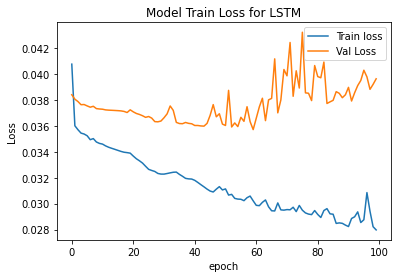

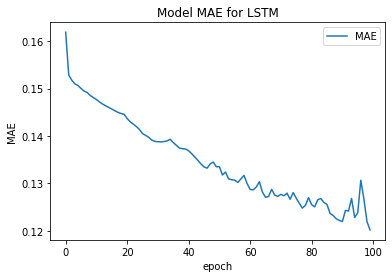

In [ ]:
plot_loss(h1,'LSTM')

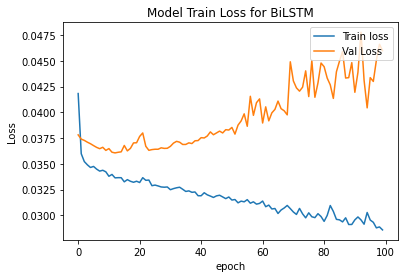

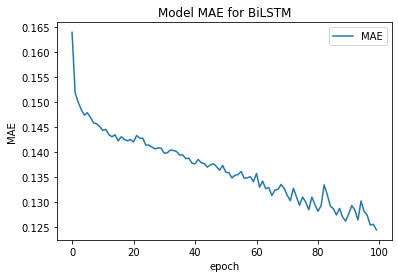

In [ ]:
plot_loss(h2,'BiLSTM')

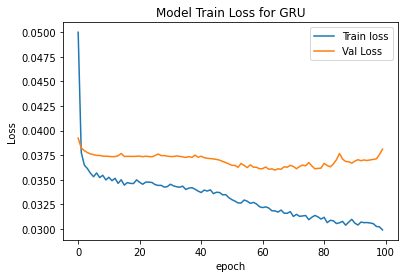

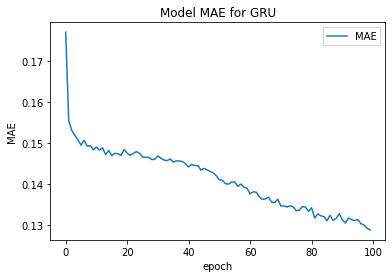

In [ ]:
plot_loss(h3,'GRU')

RMSE(LSTM)=  0.1539346182616471
RMSE(BiLSTM)=  0.1849113556871079
RMSE(GRU)=  0.12258421936697161


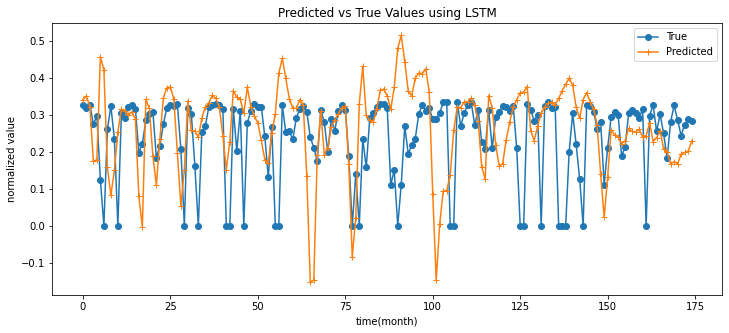

<Figure size 432x288 with 0 Axes>

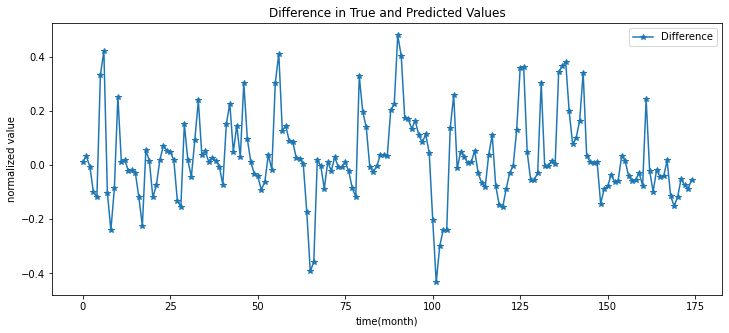

In [ ]:
yhat1_mean=(np.mean(yhat1,axis=1))
yhat2_mean=(np.mean(yhat2,axis=1))
yhat3_mean=(np.mean(yhat3,axis=1))
ytest_mean=(np.mean(ytest,axis=1))
print("RMSE(LSTM)= ",sqrt(mean_squared_error(ytest_mean,yhat1_mean)))
print("RMSE(BiLSTM)= ",sqrt(mean_squared_error(ytest_mean,yhat2_mean)))
print("RMSE(GRU)= ",sqrt(mean_squared_error(ytest_mean,yhat3_mean)))

compareall(ytest_mean,yhat1_mean,'LSTM')

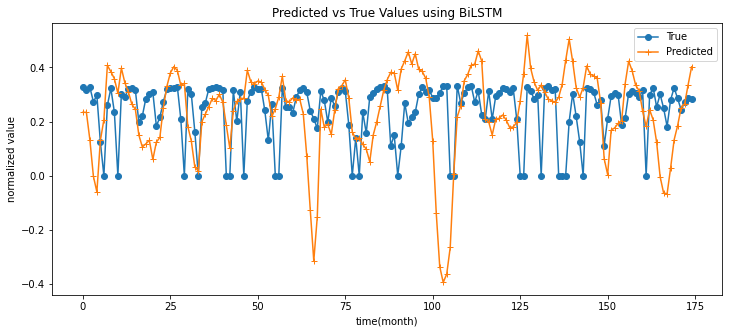

<Figure size 432x288 with 0 Axes>

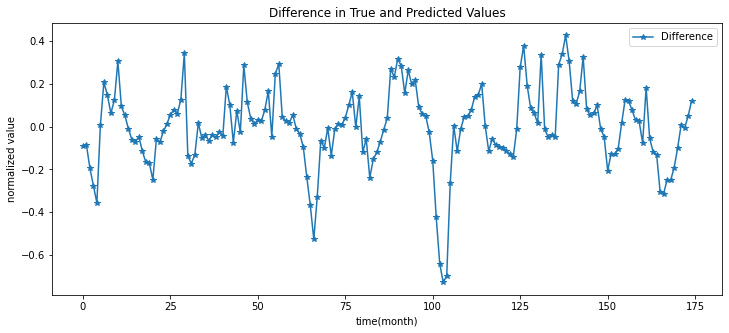

In [ ]:
compareall(ytest_mean,yhat2_mean,'BiLSTM')

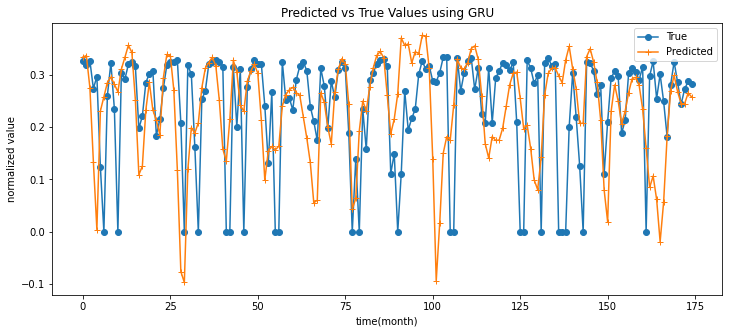

<Figure size 432x288 with 0 Axes>

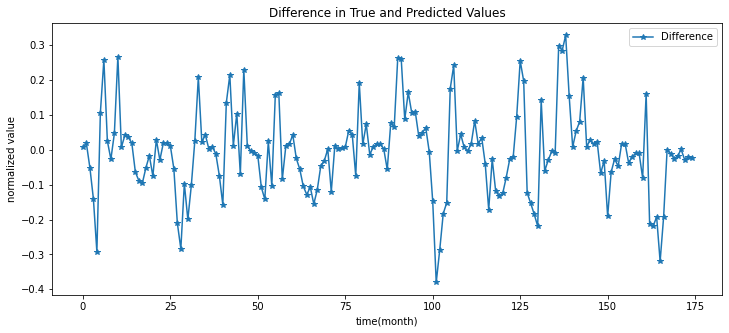

In [ ]:
compareall(ytest_mean,yhat3_mean,'GRU')

**Prediction for last 15 years**

starts from 1164th of total no of windows 

In [ ]:
lstm_pred_15year=m1.predict(x[1164:,:,:])
bilstm_pred_15year=m2.predict(x[1164:,:,:])
gru_pred_15year=m3.predict(x[1164:,:,:])
newy=(y[1164:,4:5])
yhat1_mean=(np.mean(lstm_pred_15year,axis=1))
yhat2_mean=(np.mean(bilstm_pred_15year,axis=1))
yhat3_mean=(np.mean(gru_pred_15year,axis=1))
ytest_mean=(np.mean(newy,axis=1))
print('RMSE(lstm):',sqrt(mean_squared_error(newy,lstm_pred_15year)))
print('RMSE(bilstm):',sqrt(mean_squared_error(newy,bilstm_pred_15year)))
print('RMSE(gru):',sqrt(mean_squared_error(newy,gru_pred_15year)))

RMSE(lstm): 0.18275718466456772
RMSE(bilstm): 0.2078464279222881
RMSE(gru): 0.15381729987082854


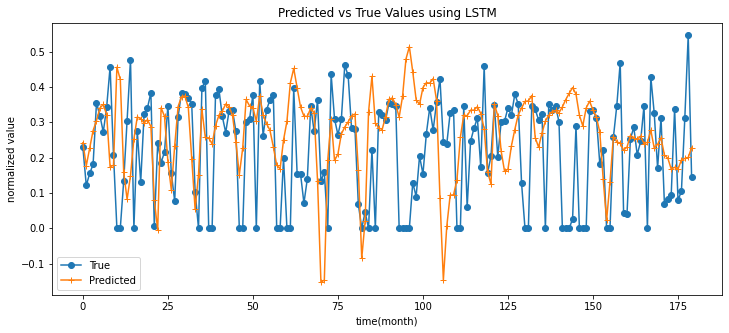

<Figure size 432x288 with 0 Axes>

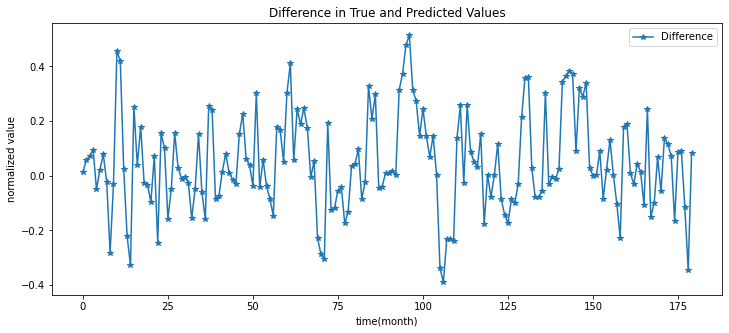

In [ ]:
compareall(ytest_mean,yhat1_mean,'LSTM')

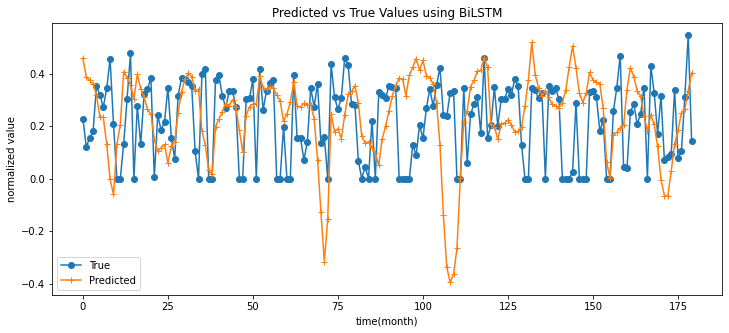

<Figure size 432x288 with 0 Axes>

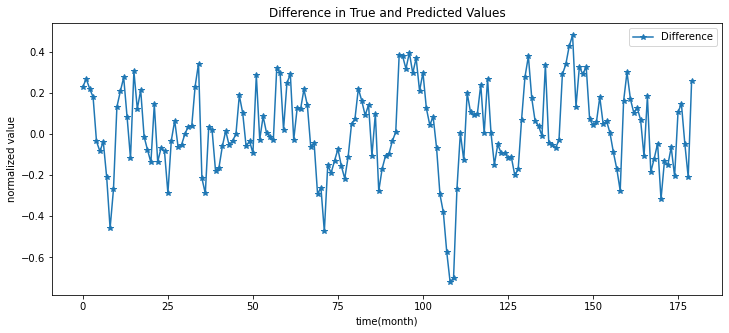

In [ ]:
compareall(ytest_mean,yhat2_mean,'BiLSTM')

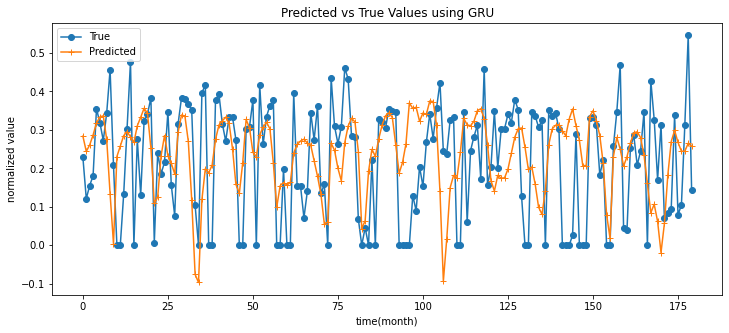

<Figure size 432x288 with 0 Axes>

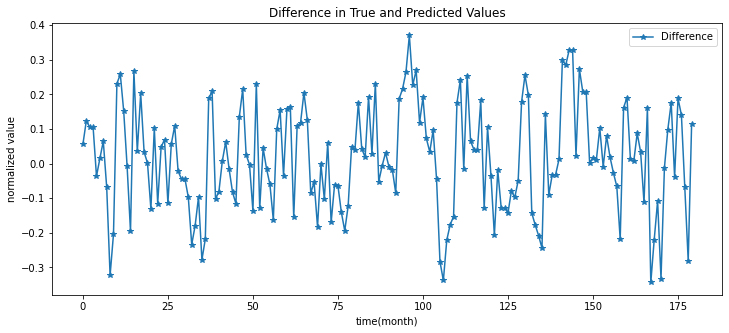

In [ ]:
compareall(ytest_mean,yhat3_mean,'GRU')

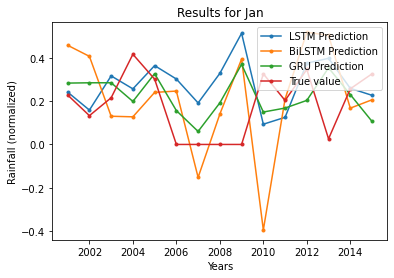

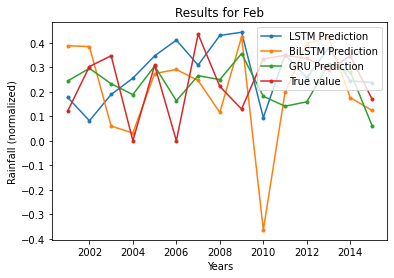

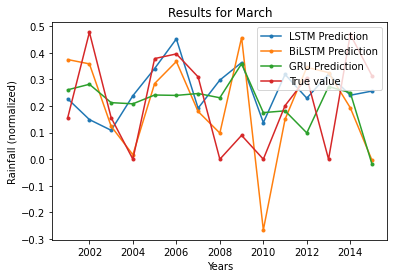

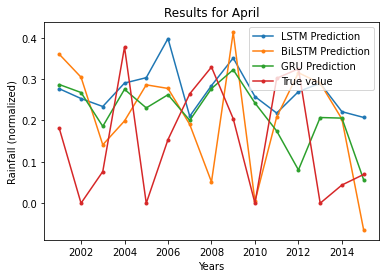

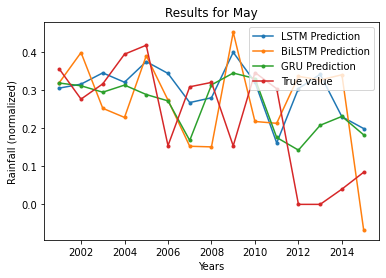

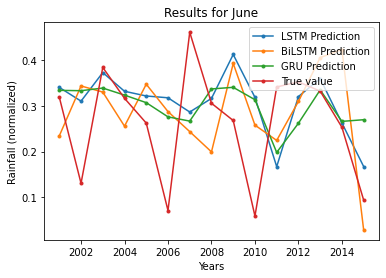

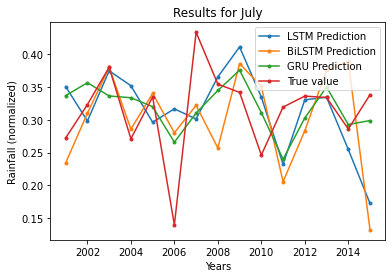

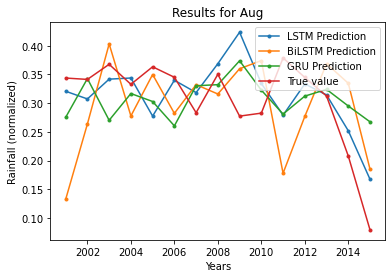

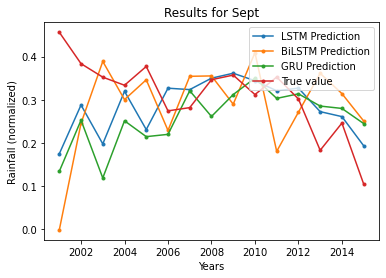

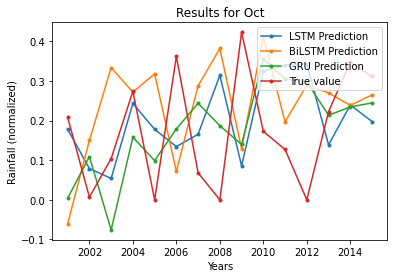

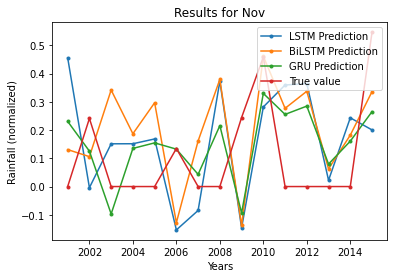

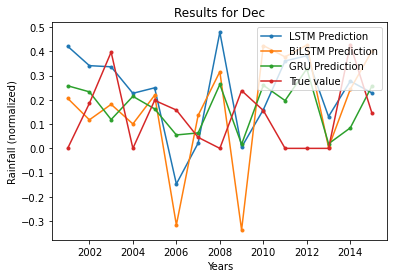

In [ ]:
for i in range(len(months)):
  actual=newy[i:180:12]
  lstm_pred=lstm_pred_15year[i:180:12]
  bilstm_pred=bilstm_pred_15year[i:180:12]
  gru_pred=gru_pred_15year[i:180:12]
  p1=plt.figure(i)
  plt.plot(np.arange(2001,2016),lstm_pred,label='LSTM Prediction',marker='.')
  plt.plot(np.arange(2001,2016),bilstm_pred,label='BiLSTM Prediction',marker='.')
  plt.plot(np.arange(2001,2016),gru_pred,label='GRU Prediction',marker='.')
  plt.plot(np.arange(2001,2016),actual,label='True value',marker='.')
  plt.title('Results for ' + months[i])
  plt.ylabel('Rainfall (normalized)')
  plt.xlabel('Years')
  plt.legend(loc='upper right')

<Figure size 432x288 with 0 Axes>

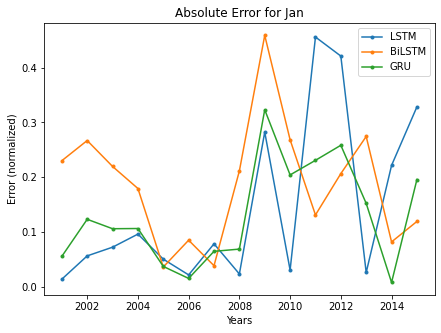

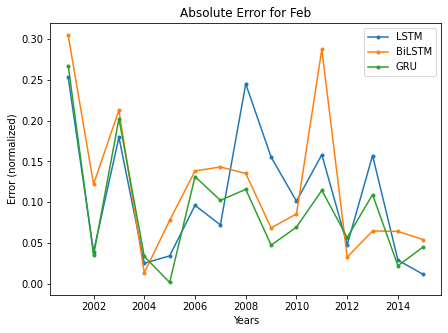

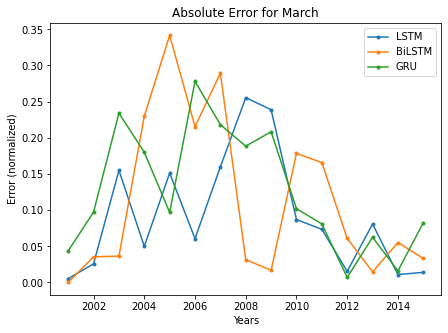

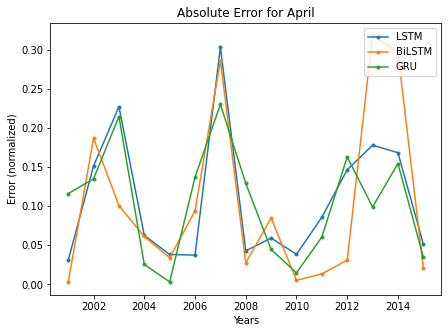

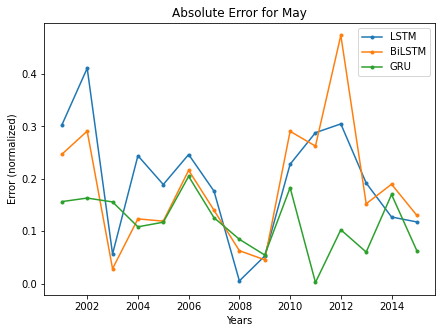

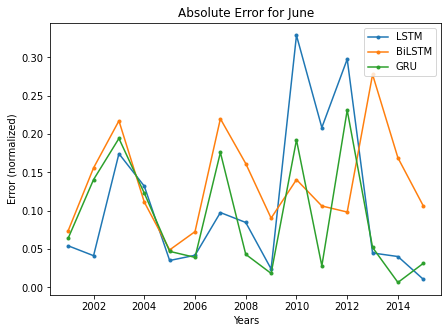

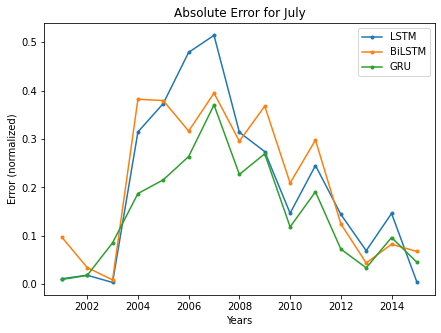

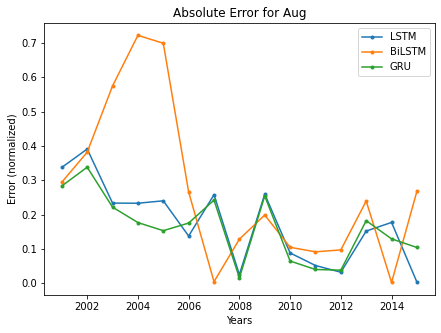

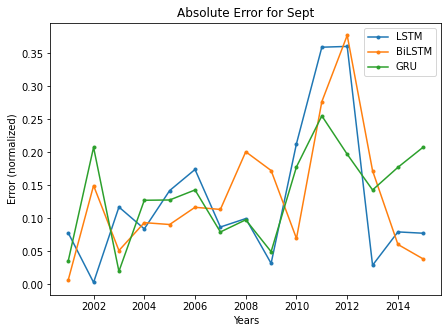

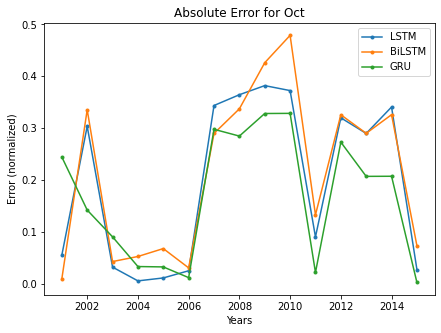

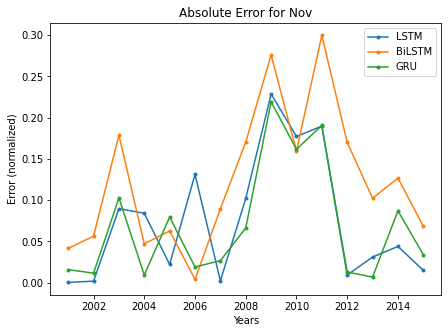

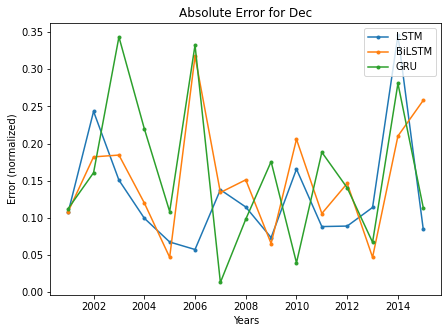

In [ ]:
lstm_pred_15year=lstm_pred_15year.reshape(12,15)
bilstm_pred_15year=bilstm_pred_15year.reshape(12,15)
gru_pred_15year=gru_pred_15year.reshape(12,15)
newy=newy.reshape(12,15)
for i in range(12):
  p1=plt.figure(i)
  plt.figure(figsize = (7, 5))
  plt.plot(np.arange(2001,2016),abs(lstm_pred_15year[i]-newy[i]),marker='.',label='LSTM')
  plt.plot(np.arange(2001,2016),abs(bilstm_pred_15year[i]-newy[i]),marker='.',label='BiLSTM')
  plt.plot(np.arange(2001,2016),abs(gru_pred_15year[i]-newy[i]),marker='.',label='GRU')
  plt.title('Absolute Error for ' + months[i])
  plt.ylabel('Error (normalized)')
  plt.xlabel('Years')
  plt.legend(loc='upper right')
